In [1]:
import zipfile

from PIL import Image, ImageDraw
import pytesseract
import cv2 as cv
import numpy as np
import os
import shutil
from IPython.display import display

# loading the face detection classifier
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [2]:
def clear_directory(output_dir):
    if os.path.exists(output_dir):
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        os.makedirs(output_dir)


In [3]:
def extract_zip(zip_path, output_dir):
    clear_directory(output_dir)
    with zipfile.ZipFile(zip_path, "r") as zippie:
        zippie.extractall(output_dir)
        return output_dir   

In [4]:
def list_of_files(output_dir):
    return os.listdir(output_dir)

In [5]:
def access_file(output_dir):
    files = os.listdir(output_dir)
    return files

In [7]:
def read_text_from_files(output_dir):
    list_of_texts = []
    files = access_file(output_dir)
    for file in files:
        pic = Image.open(output_dir+"/"+file)
        if pic.mode!="1":
            pic.convert("1")
        words = pytesseract.image_to_string(pic)
        list_of_texts.append(words)
    return list_of_texts           

In [8]:
def rec_faces(output_dir):  
    list_of_faces = []
    for file in access_file(output_dir):
        cv_image = cv.imread(output_dir+"/"+file)
        gray = cv.cvtColor(cv_image,cv.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.334,minNeighbors=5)
        if isinstance(faces, np.ndarray):
                list_of_faces.append(faces.tolist())
        else:
            list_of_faces.append([])
    return list_of_faces        

In [11]:
def ready_contact_sheet(word, output_dir,zip_path):
        extract_zip(zip_path,output_dir)
        record = access_file(output_dir)
        faces = rec_faces(output_dir)
        text = read_text_from_files(output_dir)
        metas = zip(record,faces,text)
        face_images = []
        for meta in metas:
            if word in meta[2]:
                record = meta[0] 
                faces = meta[1]
                image = Image.open(output_dir+"/"+record)
                img_copy = image.copy()
                smaller_list = []
                for (x,y,w,h) in faces:
                    bounds = x,y,x+w,y+h
                    cropped_image = img_copy.crop(bounds)
                    cropped_image_copy = cropped_image.copy()
                    cropped_image_copy.thumbnail((100,100))
                    smaller_list.append(cropped_image_copy)       
                face_images.append(smaller_list)
                if smaller_list == []:
                    return("Results found but there were no faces in {}".format(record))
                first_image = smaller_list[0]
                contact_sheet = Image.new(first_image.mode,(first_image.width*5,first_image.height*2))
                x = 0
                y = 0
                for i,img in enumerate(smaller_list):        
                    contact_sheet.paste(img,(x,y))
                    x=x+first_image.width
                    if x>=(first_image.width*5):
                        x=0
                        y=y+first_image.height
                print("Results found in {}".format(record))        
                display(contact_sheet)         
            

Results found in a-2.png


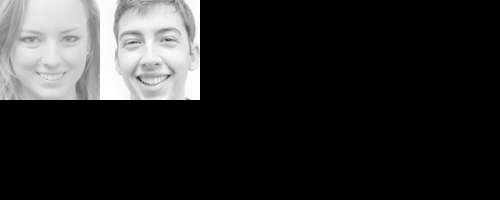

Results found in a-3.png


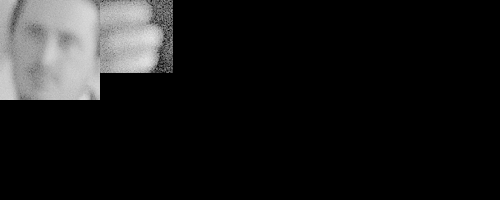

Results found in a-1.png


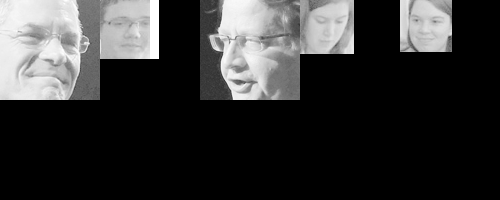

Results found in a-0.png


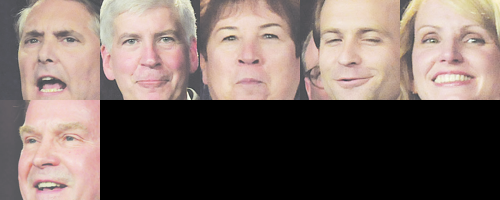

Results found in a-8.png


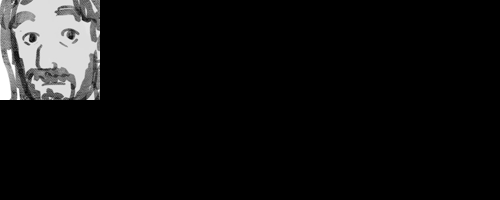

'Results found but there were no faces in a-10.png'

In [12]:
ready_contact_sheet("Mark","output_directory","/Users/BFREE/Downloads/images.zip")